# Salish Sea cruise data from 2008-2018

## Regression of pH vs DO and other variables

Regression of Salish Sea pH vs DO (and other selected variables) using data from Alin et al 2024 (https://bg.copernicus.org/articles/21/1639/2024/ and https://essd.copernicus.org/articles/16/837/2024/)

### Methods

The response variable for the regression analysis was pH_total_Lueker.

The candidate features for predictor variables were oxygen, salinity, temperature, pressure, and month of sample collection

The regression analysis was performed using three methods:

1) cross-validated optimization of the machine learning XGBoost XGBRegressor
2) cross-validated optimization of machine learning Lasso regression
3) stepwise linear regression to minimize Bayesian Information Criterion

Each of the regression methods used the following three-step cross-validation approach:

- a. train the model using 80% of the data
- b. test the trained model using the other 20% of the data
- c. final fit of the model using 100% of the data with the selected features and hyperparameters from  the training step (a)

The model skill metrics (e.g. R-squared, RMSE, etc) from step (b) provide the best estimate of how well the model is expected to perform on new data.

For regression  methods 1) and 2) the continuous features (oxygen, salinity, temperature, pressure) were scaled with StandardScaler because of the requirements of XGBoost and Lasso regression for standardized features. For method 3) the continuous features were not scaled because it is not required for linear regression, and the results are more easily interpreted without scaling. 

The months of sample collection were one-hot encoded as categorical dummy variables for all methods (i.e. each month was assigned as a separate dummy feature with values of 0 or 1, where 1 indicates that the sample was collected in that month). 

Adding sigma-theta to the list of candidate features was also tried, but there is too much multicollinearity between salinity and sigma-theta. Therefore, salinity was selected, and sigma-theta was not included as a candidate feature.

### PyMLR

The regression analysis was applied using the PyMLR module. Before running this notebook, first install the PyMLR module in your environment using the following line:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read the data into the pandas dataframe

- df: SalishCruises_2008to2018_MeasCalcParamsToNCEI_12162024.csv (https://www.ncei.noaa.gov/data/oceans/archive/arc0218/0283266/2.2/data/0-data/)

In [3]:
fn = 'SalishCruises_2008to2018_MeasCalcParamsToNCEI_12162024.csv'
df = pd.read_csv(fn)

### Show the data types in the dataframe

Shown below are the following properties for each column of the dataframe:

- dtype
- nunique: number of unique values
- isna_sum: number of missing values (nan or None)
- zero_sum: sum of all the values in the column that are equal to zero
- one_sum: sum of all the values in the column that are equal to one

In [5]:
from PyMLR import show_dtypes
df_dtypes = show_dtypes(df)

                              dtype nunique isna_sum zero_sum one_sum
record                        int64    3971        0        0       1
EXPOCODE                     object      33        0        0       0
CRUISE_ID                    object      33        0        0       0
DATE_UTC                     object     130        0        0       0
TIME_UTC                     object    3288        0        0       0
DATE_LOCAL                   object     129        0        0       0
TIME_LOCAL                   object    3282        0        0       0
LONGITUDE_DEC               float64    1296        0        0       0
LATITUDE_DEC                float64    1417        0        0       0
STATION_NO                    int64      57        0        0      84
NISKIN_NO                     int64      24        0        0     549
MONTH_UTC                     int64      10        0        0       9
DAY_UTC                       int64      29        0        0     127
YEAR_UTC            

### Select the features

The following features will be used for the independent variables to predict pH

In [6]:
candidate_features = [
    'RECOMMENDED_OXYGEN_MG_L',
    'MONTH_UTC',
    'CTDPRS_DBAR',
    'CTDTMP_DEG_C_ITS90',
    'CTDSAL_PSS78'
]

### Define X and y for the regression

In [7]:
X = df[candidate_features]
y = df['pH_total_Lueker']

### Split X and y into train and test subsets

In [8]:
# Split X and y into cross-validation train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Method 1. XGBoost regression

### a. Train the model with the training subset to find the optimum hyperparameters and selected features

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...

XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.980504    |
| MSE                |    0.00070482  |
| RMSE               |    0.0265484   |
| Explained Variance |    0.9806      |
| MAE                |    0.0165104   |
| Max Error          |    0.245363    |
| MAPE               |    0.00212217  |
| MSLE               |    9.10412e-06 |
| n_samples          | 3176           |

Done
Time elapsed: 1245.51 sec



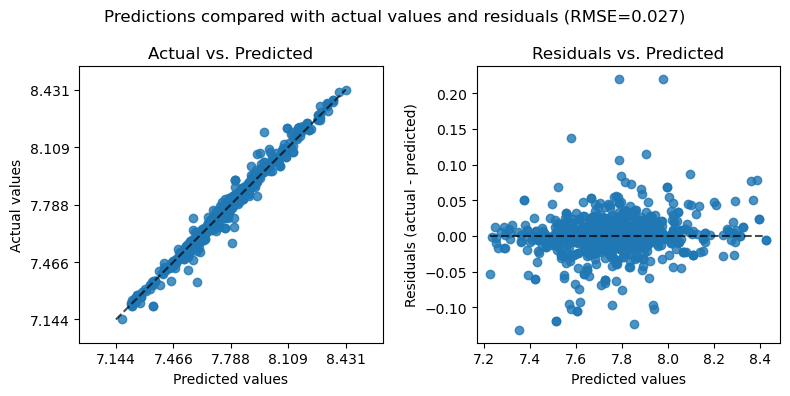

In [16]:
# Train the model with the training data subset
from PyMLR import xgb_auto
train_model_xgb, train_output_xgb = xgb_auto(X_train, y_train)

### b. Test the model with the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |     Regressor |
|:-------------------|--------------:|
| R-squared          |   0.895431    |
| MSE                |   0.00432312  |
| RMSE               |   0.0657504   |
| Explained Variance |   0.895432    |
| MAE                |   0.0414374   |
| Max Error          |   0.368955    |
| MAPE               |   0.00532688  |
| MSLE               |   5.58109e-05 |
| n_samples          | 795           |



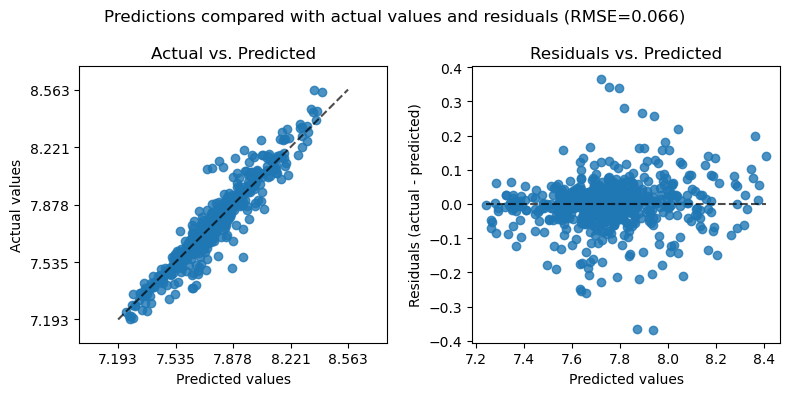

In [17]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output = test_model(train_model_xgb, X_test, y_test, 
    preprocess_result= train_output_xgb['preprocess_result'],
    selected_features= train_output_xgb['selected_features'])

# save the plot of predictions vs actual and residuals
test_output['fig'].savefig("XGBRegressor_predictions_test_Salish_Sea_pH_vs_DO_mgl.png", dpi=300)

### c(i). Final fit using all of the data with hyperparameters and selected features from the training optimization

Fitting XGBRegressor model, please wait ...


XGBRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   XGBRegressor |
|:-------------------|---------------:|
| R-squared          |    0.980919    |
| MSE                |    0.000709643 |
| RMSE               |    0.0266391   |
| Explained Variance |    0.981009    |
| MAE                |    0.016607    |
| Max Error          |    0.275433    |
| MAPE               |    0.00213555  |
| MSLE               |    9.18731e-06 |
| n_samples          | 3971           |

Done
Time elapsed: 4.40 sec



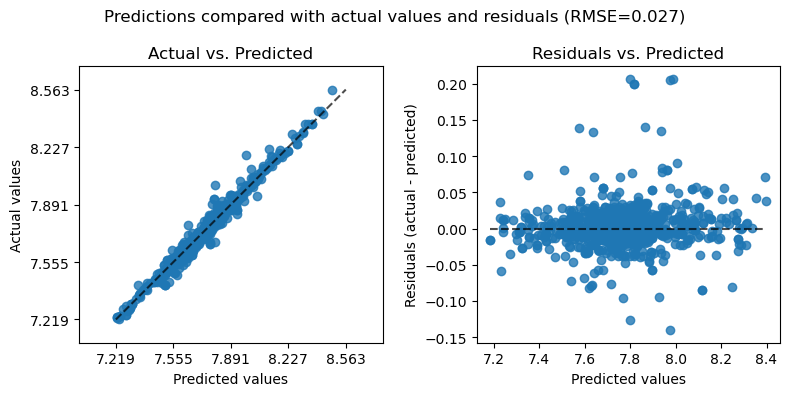

In [18]:
# Final fit of the model using all of the X and y data
from PyMLR import xgb
final_model_xgb, final_output_xgb = xgb(X, y, 
    **train_output_xgb['best_params'],
    selected_features= train_output_xgb['selected_features'])

### c(ii). Selected features from the fitted model

The optimization of XGBoost regression found the following set of selected features to be the optimum set for minimization of the MSE

In [19]:
train_output_xgb['selected_features']

['MONTH_UTC_1',
 'MONTH_UTC_3',
 'MONTH_UTC_4',
 'MONTH_UTC_5',
 'MONTH_UTC_7',
 'MONTH_UTC_9',
 'MONTH_UTC_10',
 'RECOMMENDED_OXYGEN_MG_L',
 'CTDPRS_DBAR',
 'CTDTMP_DEG_C_ITS90',
 'CTDSAL_PSS78']

# Method 2. Lasso regression

### a. Train the model using the training subset to find the optimum hyperparameters and selected features

Fitting Lasso regression models, please wait ...

Lasso regression statistics of best models in model_outputs['stats']:

| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     0.000163259 |     0           |     8.56438e-18 |     0.000300245 |
| r-squared          |     0.813047    |     0.813608    |     0.813608    |     0.81254     |
| adjusted r-squared |     0.812159    |     0.812782    |     0.812782    |     0.811889    |
| n_samples          |  3176           |  3176           |  3176           |  3176           |
| df residuals       |  3161           |  3162           |  3162           |  3165           |
| df model           |    14           |    13           |    13           |    10           |
| F-statistic        |   981.926       |  1061.71        |  1061.71        |  1371.86        |
| Prob (F-statistic) |  

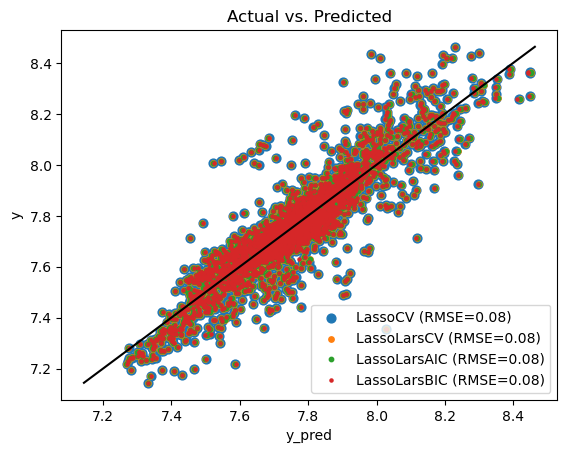

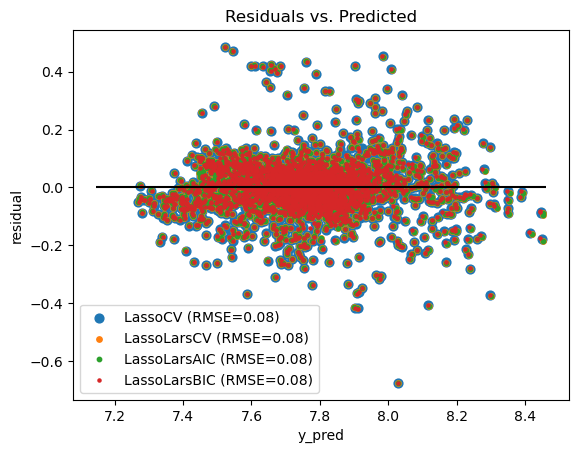

In [9]:
# Train the model with the training data subset
from PyMLR import lasso
train_model_lasso, train_output_lasso = lasso(X_train, y_train, verbose=1)

In [10]:
# Show intercept and coefficients of fitted LassoLarsBIC model (train)
from PyMLR import show_coef
fitted_model = train_model_lasso['LassoLarsBIC']
X_proc = train_output_lasso['X_processed']
popt_lasso_train = show_coef(fitted_model, X_proc)

| Feature                 |   Parameter |
|:------------------------|------------:|
| Intercept               |  7.7588     |
| MONTH_UTC_1             |  0          |
| MONTH_UTC_2             | -0.0910355  |
| MONTH_UTC_3             |  0          |
| MONTH_UTC_4             | -0.0161148  |
| MONTH_UTC_5             |  0.0233631  |
| MONTH_UTC_7             |  0.0158971  |
| MONTH_UTC_8             |  0.0454342  |
| MONTH_UTC_9             | -0.00496913 |
| MONTH_UTC_10            |  0          |
| MONTH_UTC_11            |  0          |
| RECOMMENDED_OXYGEN_MG_L |  0.188939   |
| CTDPRS_DBAR             |  0.00969141 |
| CTDTMP_DEG_C_ITS90      |  0.0219801  |
| CTDSAL_PSS78            |  0.0426271  |


### b. Test the model using the testing subset


Goodness of fit to testing data in result['metrics']:

| Statistic          |     Regressor |
|:-------------------|--------------:|
| R-squared          |   0.821637    |
| MSE                |   0.00737392  |
| RMSE               |   0.0858716   |
| Explained Variance |   0.821669    |
| MAE                |   0.0577552   |
| Max Error          |   0.644237    |
| MAPE               |   0.00743294  |
| MSLE               |   9.45508e-05 |
| n_samples          | 795           |



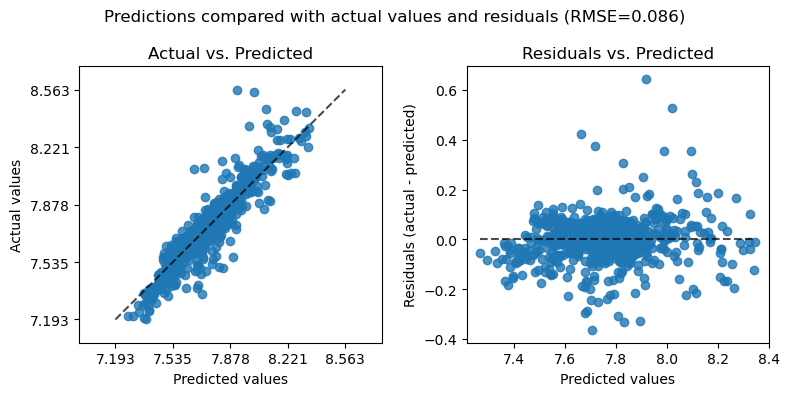

In [11]:
# Test the model with the testing data subset
from PyMLR import test_model
test_output = test_model(train_model_lasso['LassoLarsBIC'], X_test, y_test, 
    preprocess_result= train_output_lasso['preprocess_result'],
    selected_features= train_output_lasso['selected_features'])

# save the plot of predictions vs actual and residuals
test_output['fig'].savefig("LassoLarsBIC_predictions_test_Salish_Sea_pH_vs_DO_mgl.png", dpi=300)

### c(i). Final fit using all of the data with selected features from the training optimization

Fitting Lasso regression models, please wait ...

Lasso regression statistics of best models in model_outputs['stats']:

| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     0.000166351 |     9.1306e-05  |     1.02886e-17 |     0.00032853  |
| r-squared          |     0.815561    |     0.815952    |     0.81612     |     0.814986    |
| adjusted r-squared |     0.814861    |     0.815301    |     0.81547     |     0.814472    |
| n_samples          |  3971           |  3971           |  3971           |  3971           |
| df residuals       |  3956           |  3957           |  3957           |  3960           |
| df model           |    14           |    13           |    13           |    10           |
| F-statistic        |  1249.49        |  1349.45        |  1350.96        |  1744.37        |
| Prob (F-statistic) |  

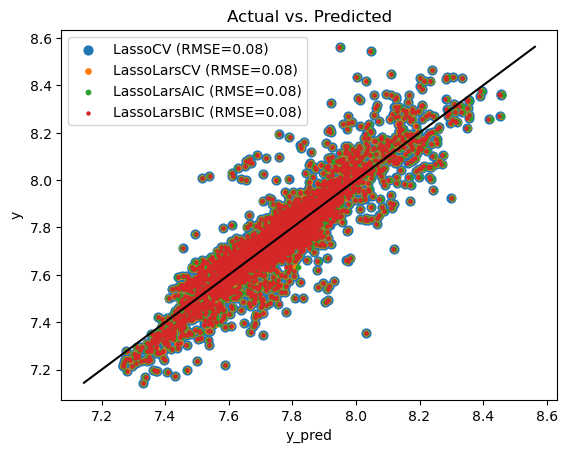

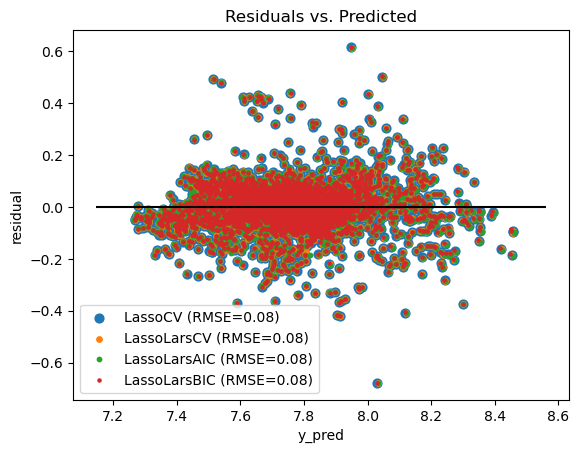

In [12]:
# Final fit of the model using all of the X and y data
from PyMLR import lasso
final_model_lasso, final_output_lasso = lasso(X, y, verbose=1,
    selected_features= train_output_lasso['selected_features'])

### c(ii). Show the intercept and coefficients of the final fitted Lasso model

In [13]:
# Show intercept and coefficients of fitted LassoLarsBIC model (final)
from PyMLR import show_coef
fitted_model = final_model_lasso['LassoLarsBIC']
X_proc = final_output_lasso['X_processed']
popt_lasso_final = show_coef(fitted_model, X_proc)

| Feature                 |   Parameter |
|:------------------------|------------:|
| Intercept               |  7.76168    |
| MONTH_UTC_1             |  0          |
| MONTH_UTC_2             | -0.0945307  |
| MONTH_UTC_3             |  0          |
| MONTH_UTC_4             | -0.0223208  |
| MONTH_UTC_5             |  0.0241827  |
| MONTH_UTC_7             |  0.01221    |
| MONTH_UTC_8             |  0.0432102  |
| MONTH_UTC_9             | -0.00928211 |
| MONTH_UTC_10            |  0          |
| MONTH_UTC_11            |  0          |
| RECOMMENDED_OXYGEN_MG_L |  0.191216   |
| CTDPRS_DBAR             |  0.00967994 |
| CTDTMP_DEG_C_ITS90      |  0.0202797  |
| CTDSAL_PSS78            |  0.0399091  |


# Method 3. Stepwise regression to minimize BIC

### a(i). Fit the model with the training data using PyMLR stepwise to find optimum selected features

Fitting models for all 16384 subsets of features, this may take up to a minute, please wait ...

Best 10 subsets of features in model_outputs['step_features']:

|   Rank |      AIC |      BIC |   rsq_adj | Features                                                                 |
|-------:|---------:|---------:|----------:|:-------------------------------------------------------------------------|
|      0 | -6833.5  | -6772.86 |  0.812303 | ['RECOMMENDED_OXYGEN_MG_L' 'CTDPRS_DBAR' 'CTDTMP_DEG_C_ITS90'            |
|        |          |          |           |  'CTDSAL_PSS78' 'MONTH_UTC_1' 'MONTH_UTC_2' 'MONTH_UTC_5' 'MONTH_UTC_7'  |
|        |          |          |           |  'MONTH_UTC_8']                                                          |
|      1 | -6833.5  | -6772.86 |  0.812303 | ['RECOMMENDED_OXYGEN_MG_L' 'CTDPRS_DBAR' 'CTDTMP_DEG_C_ITS90'            |
|        |          |          |           |  'CTDSAL_PSS78' 'MONTH_UTC_1' 'MONTH_UTC_2' 'MONTH_UTC_5' 'MONTH_UTC_7'  |

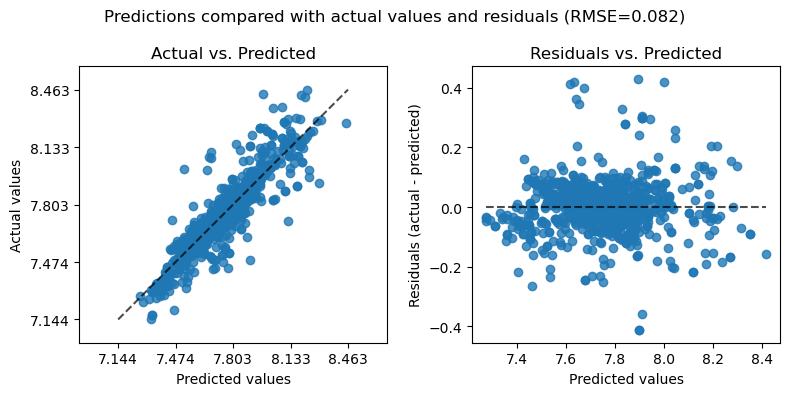

In [14]:
# Train the model with the training data subset
from PyMLR import stepwise
train_model_stepBIC, train_output_stepBIC = stepwise(
    X_train, y_train, criterion='bic', use_scaler=False,
    allow_dummies=True, direction='all')

### a(ii). Fit the model to the training data using PyMLR linear with the selected features from PyMLR stepwise BIC

This step converts the training model from a(i) into an sklearn model object to allow use to more easily look at model agnostics

Fitting LinearRegression model, please wait ...

LinearRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LinearRegression |
|:-------------------|-------------------:|
| r-squared          |        0.812835    |
| adjusted r-squared |        0.812303    |
| n_samples          |     3176           |
| df residuals       |     3167           |
| df model           |        8           |
| F-statistic        |     1719.24        |
| Prob (F-statistic) |        1.11022e-16 |
| RMSE               |        0.0822584   |
| Log-Likelihood     |     3426.75        |
| AIC                |    -6835.5         |
| BIC                |    -6780.93        |

Parameters of fitted model in model_outputs['popt']:

| Feature                 |    Parameter |
|:------------------------|-------------:|
| Intercept               |  6.28595     |
| RECOMMENDED_OXYGEN_MG_L |  0.0814823   |
| CTDPRS_DBAR             |  0.000175003 |
| CTDTMP_DEG_C_ITS90      |  0.

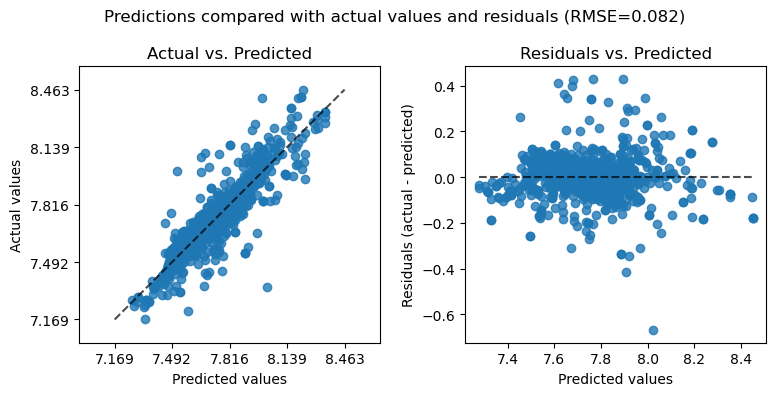

In [15]:
from PyMLR import linear
train_model_linear, train_output_linear = linear(
    X_train, y_train, 
    use_scaler=False,
    selected_features = train_output_stepBIC['selected_features']
    )

### b. Test the trained model with the testing data and the selected features from stepwise BIC training


Goodness of fit to testing data in result['metrics']:

| Statistic          |     Regressor |
|:-------------------|--------------:|
| R-squared          |   0.82048     |
| MSE                |   0.00742177  |
| RMSE               |   0.0861497   |
| Explained Variance |   0.820512    |
| MAE                |   0.0578412   |
| Max Error          |   0.658792    |
| MAPE               |   0.0074421   |
| MSLE               |   9.50684e-05 |
| n_samples          | 795           |



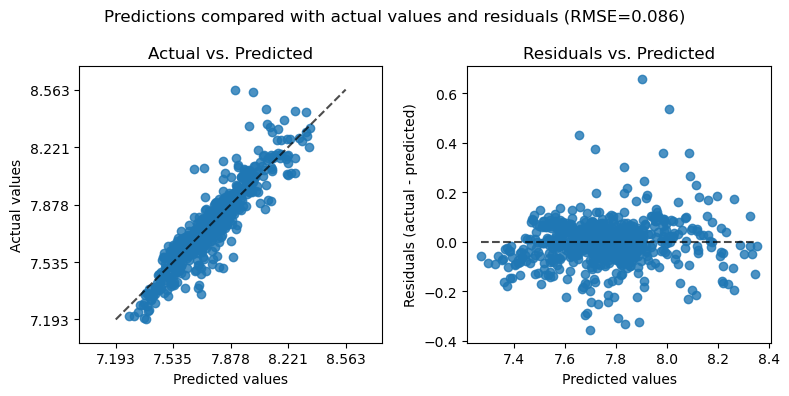

In [16]:
from PyMLR import test_model
test_output_linear = test_model(train_model_linear, X_test, y_test, 
    preprocess_result= train_output_linear['preprocess_result'],
    selected_features= train_output_linear['selected_features'])

# save the plot of predictions vs actual and residuals
test_output['fig'].savefig("LinearRegression_predictions_test.png", dpi=300)

### c. Final fit of a linear regression model to all of the data with selected features from stepwise BIC training

Fitting LinearRegression model, please wait ...

LinearRegression goodness of fit to training data in model_outputs['stats']:

| Statistic          |   LinearRegression |
|:-------------------|-------------------:|
| r-squared          |        0.814807    |
| adjusted r-squared |        0.814387    |
| n_samples          |     3971           |
| df residuals       |     3962           |
| df model           |        8           |
| F-statistic        |     2178.99        |
| Prob (F-statistic) |        1.11022e-16 |
| RMSE               |        0.0829913   |
| Log-Likelihood     |     4249.29        |
| AIC                |    -8480.58        |
| BIC                |    -8424           |

Parameters of fitted model in model_outputs['popt']:

| Feature                 |    Parameter |
|:------------------------|-------------:|
| Intercept               |  6.33511     |
| RECOMMENDED_OXYGEN_MG_L |  0.0818427   |
| CTDPRS_DBAR             |  0.000168673 |
| CTDTMP_DEG_C_ITS90      |  0.

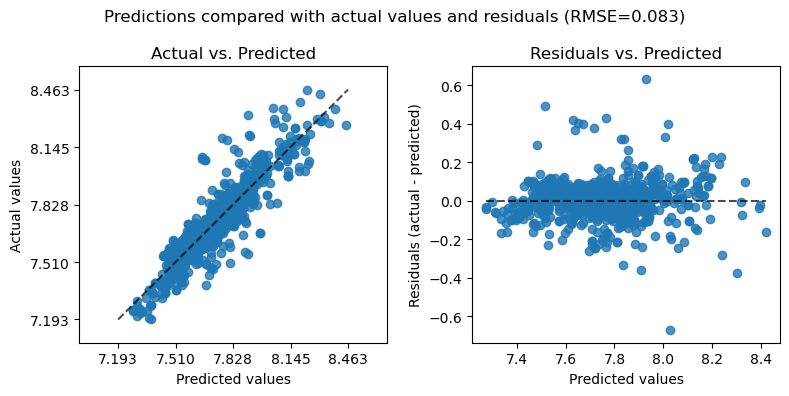

In [17]:
from PyMLR import linear
final_model_linear, final_output_linear = linear(
    X, y, 
    use_scaler=False,
    selected_features = train_output_stepBIC['selected_features']
    )

### d. Model agnostics using predictions from test data from the mode that was fit to the training data

Performing 4-step model agnostic analysis, please wait...

Step 1: Model skill metrics and residuals plot, please wait...

Model skill metrics:

| Statistic          |     Regressor |
|:-------------------|--------------:|
| R-squared          |   0.82048     |
| MSE                |   0.00742177  |
| RMSE               |   0.0861497   |
| Explained Variance |   0.820512    |
| MAE                |   0.0578412   |
| Max Error          |   0.658792    |
| MAPE               |   0.0074421   |
| MSLE               |   9.50684e-05 |
| n_samples          | 795           |



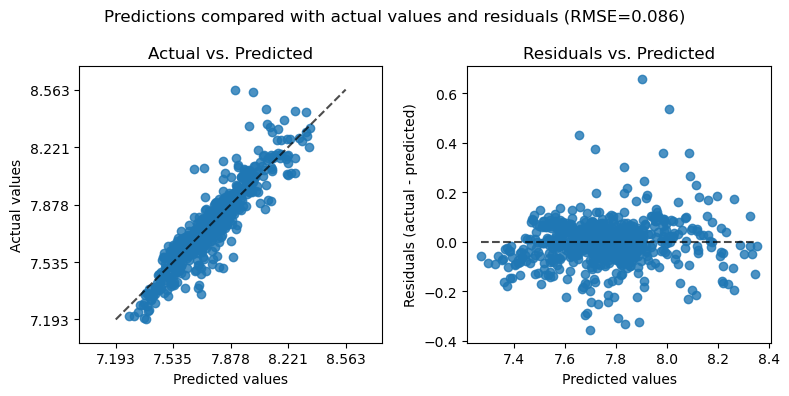

Step 2: SHAP Beeswarm and Bar importance...


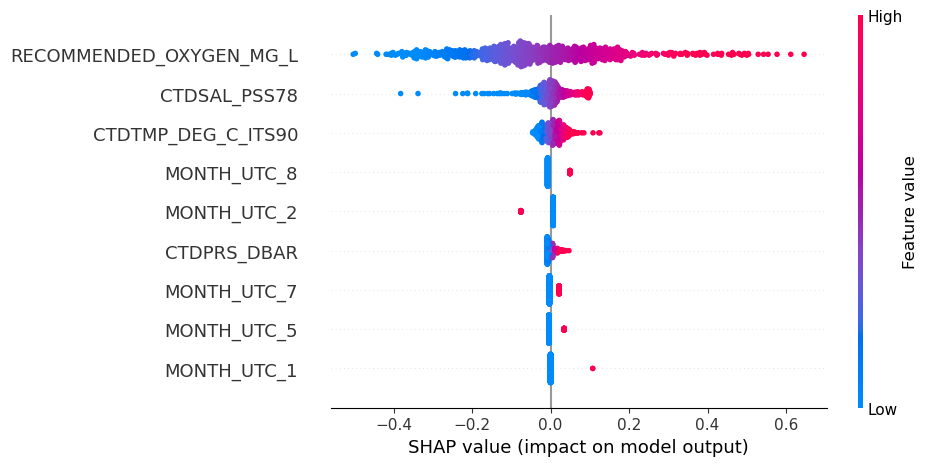

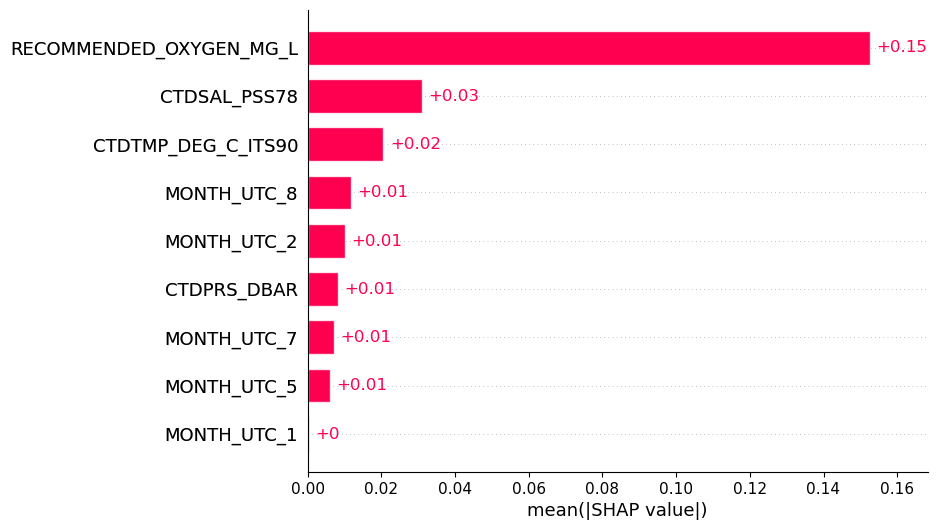

Step 3: Permutation Importance...


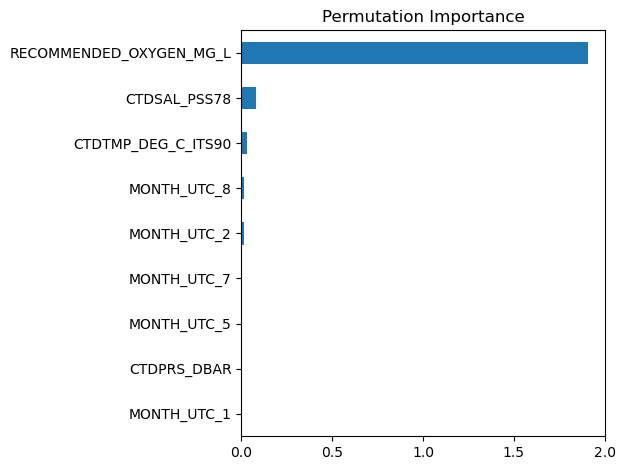

Step 4: PDP + ICE plots of each continuous features...
processing feature:  RECOMMENDED_OXYGEN_MG_L


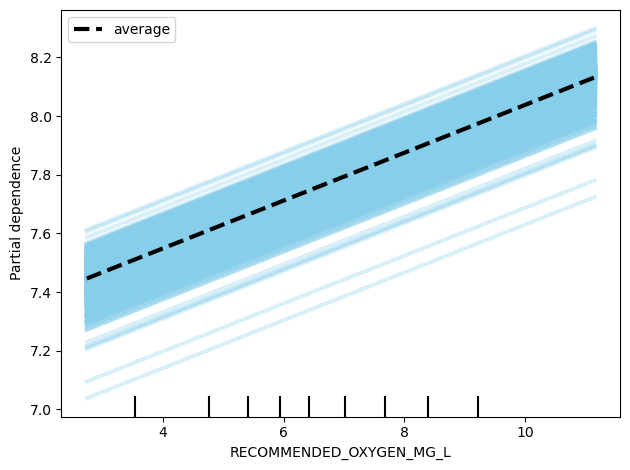

processing feature:  CTDSAL_PSS78


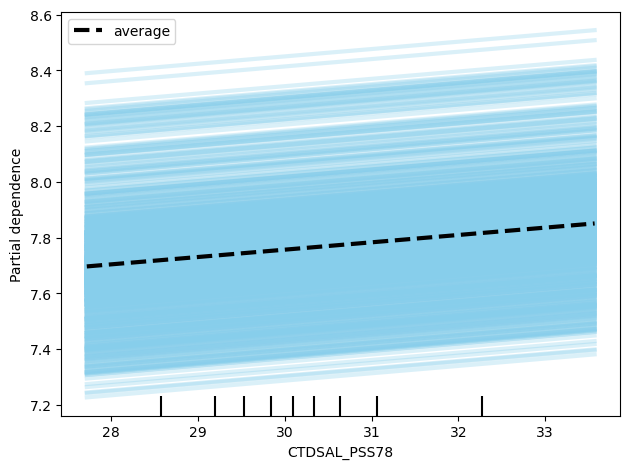

processing feature:  CTDTMP_DEG_C_ITS90


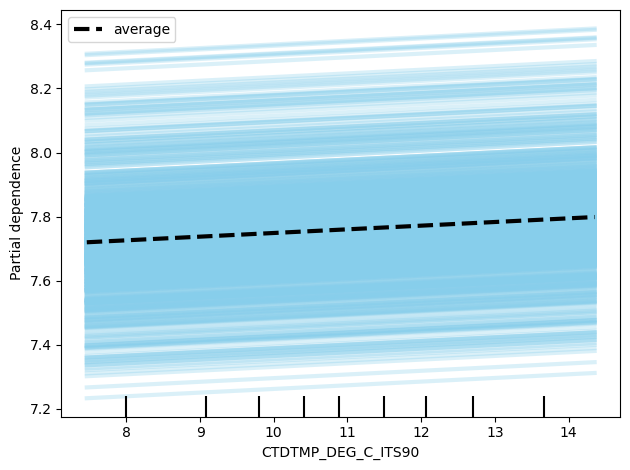

processing feature:  CTDPRS_DBAR


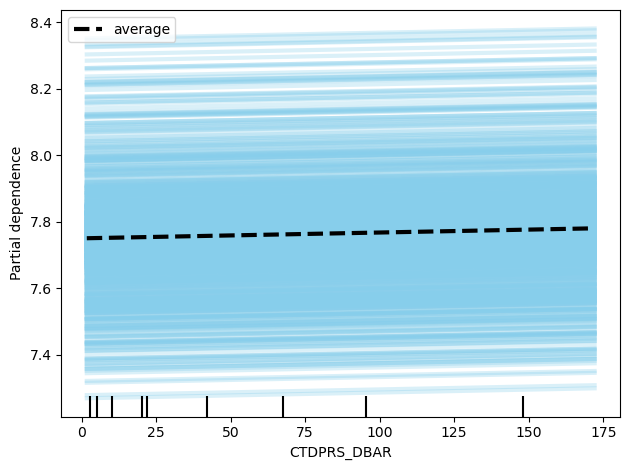

Interpretability plots saved to: model_agnostic
Done
Time elapsed: 6.35 sec



In [19]:
# Model agnostics
from PyMLR import model_agnostic
agnostic_output_linear = model_agnostic(train_model_linear, X_test, y_test, 
    preprocess_result= train_output_linear['preprocess_result'],
    selected_features= train_output_linear['selected_features'],
    output_dir= 'model_agnostic',
    show=True)